In [72]:
 #check gpu
!nvidia-smi

Fri May 27 10:36:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |   4134MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [73]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=False)


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [74]:
!ls gdrive/MyDrive/Colab\ Notebooks\ 2/NLP/ImageCaption

ls: cannot access 'gdrive/MyDrive/Colab Notebooks 2/NLP/ImageCaption': No such file or directory


In [75]:
cd gdrive/MyDrive/Colab\ Notebooks\ 2/NLP/ImageCaption

[Errno 2] No such file or directory: 'gdrive/MyDrive/Colab Notebooks 2/NLP/ImageCaption'
/content/gdrive/MyDrive/Colab Notebooks 2/NLP/ImageCaption


In [76]:
!ls

 checkpoint_imagecaption	   glove.6B
'Copy of Image_to_caption.ipynb'   Image_to_caption_GoogleColab.ipynb
 Flickr8k_1			   runimg.jpg


In [77]:
import tensorflow as tf

In [78]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [79]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

import tensorflow as tf
from tensorflow import keras
from keras import Input, layers
from keras import optimizers



# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer

# from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model

# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

### Flickr8k

it is a dataset that contains 8000 images and each image has 5 caption about it written in the txt files.

In [80]:
!ls Flickr8k_1/Flickr8k_text

CrowdFlowerAnnotations.txt  Flickr8k.lemma.token.txt  Flickr_8k.trainImages.txt
ExpertAnnotations.txt	    Flickr_8k.testImages.txt  __MACOSX
Flickr_8k.devImages.txt     Flickr8k.token.txt	      readme.txt


In [81]:
token_path = "Flickr8k_1/Flickr8k_text/Flickr8k.token.txt"
train_images_path = 'Flickr8k_1/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'Flickr8k_1/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = 'Flickr8k_1/Flicker8k_images/'
# glove_path = 'glove.6B/glove.6B.200d.txt'
glove_path = 'glove.6B/'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


**Next, we create a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values.**



In [82]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)


In [83]:
desc = descriptions['1000268201_693b08cb0e'][0]
table2 = str.maketrans('', '', string.punctuation)
desc = desc.lower()
desc = desc.split(' ')
desc = [w.translate(table2) for w in desc]
desc =  ' '.join(desc)
desc

'a child in a pink dress is climbing up a set of stairs in an entry way '

### Now let’s perform some basic text clean to get rid of punctuation and convert our descriptions to lowercase.

In [84]:
table = str.maketrans('', '', string.punctuation)

for key in descriptions:
    desc_list = descriptions[key] #list of 5 captions
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.lower()
        desc = desc.split(' ')
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)
    

### Let's visualize an example image

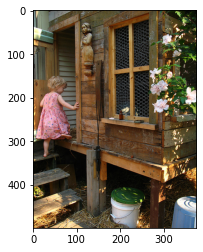

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [85]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']


### Next, we create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions in the data set. We have 8828 unique words across all the 40000 image captions.



In [86]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))


Original Vocabulary Size: 8828


### Now let’s save the image id’s and their new cleaned captions in the same format as the token.txt file:-



In [87]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)


In [88]:
lines[0] # contains the image id and caption in one line

'1000268201_693b08cb0e a child in a pink dress is climbing up a set of stairs in an entry way '

In [89]:
new_descriptions[0:95] #String that contains all the character in "lines" seperated by '\n'

'1000268201_693b08cb0e a child in a pink dress is climbing up a set of stairs in an entry way \n1'

### Next, we load all the 6000 training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file:-



In [90]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]  #remove the .jpg from the file name
      dataset.append(identifier)

train = set(dataset) # it contains the name of 6000 images that will be used for training
len(train)

6000

### Now we save all the training and testing images in train_img and test_img lists respectively:-

In [91]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)


In [92]:
train_img[0] # contains the path to all training images

'Flickr8k_1/Flicker8k_images/2178064851_bb39652d28.jpg'

In [93]:
test_img[0] # contains the path to all test images

'Flickr8k_1/Flicker8k_images/3107513635_fe8a21f148.jpg'

### Now, we load the descriptions of the training images into a dictionary. However, we will add two tokens in every caption, which are ‘startseq’ and ‘endseq’:-



In [94]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split(' ')
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)


In [95]:
train_descriptions['1000268201_693b08cb0e'] #dict mapping trainging imageID to captions

['startseq a child in a pink dress is climbing up a set of stairs in an entry way  endseq',
 'startseq a girl going into a wooden building  endseq',
 'startseq a little girl climbing into a wooden playhouse  endseq',
 'startseq a little girl climbing the stairs to her playhouse  endseq',
 'startseq a little girl in a pink dress going into a wooden cabin  endseq']

### We create a list of only the training captions

In [96]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [97]:
all_train_captions[0] #list of all training captions

'startseq a child in a pink dress is climbing up a set of stairs in an entry way  endseq'

### To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus

In [98]:
# len(vocab)

In [99]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1660


### Now we create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.



In [100]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [101]:
vocab_size

1661

In [102]:
ixtoword[1]

'startseq'

### We also need to find out what the max length of a caption can be since we cannot have captions of arbitrary length.



In [103]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)


Description Length: 38


## Glove embedding

In [104]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


In [105]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [106]:
len(embedding_matrix[0])

200

In [107]:
embedding_matrix.shape  #(vocab_size, embedding_dim)

(1661, 200)

## Model Building and Training

In [108]:
model = InceptionV3(weights='imagenet')

We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the inceptionV3 model.



In [109]:
model_new = Model(model.input, model.layers[-2].output) 

### Since we are using InceptionV3 we need to pre-process our input before feeding it into the model. Hence we define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of Keras.



In [110]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299)) 
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) 
    return x

### Now we can go ahead and encode our training and testing images, i.e extract the images vectors of shape (2048,)

`Encode` function takes input an image path and return the feature vector of that image. The feature vector is the output of the inceptionV3 model trained on imagenet dataset. 

In [111]:
def encode(imagex):
    imagex = preprocess(imagex) 
    fea_vec = model_new.predict(imagex) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)


In [112]:
train_img[0]

'Flickr8k_1/Flicker8k_images/2178064851_bb39652d28.jpg'

### Now let’s define our model. We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

* Processing the sequence from the text 
* Extracting the feature vector from the image
* Decoding the output using softmax by concatenating the above two layers


In [113]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 38, 200)      332200      ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

In [114]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [115]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


Create batches of our dataset

In [116]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0


In [117]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

In [118]:
!pip install pyyaml h5py  # Required to save models in HDF5 format`

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
import os

checkpoint_path = "checkpoint_imagecaption/cp.ckpt"

# Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)


# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

In [120]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)

### Train model

In [121]:
# model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

### Load previous weights

In [122]:
model.load_weights(checkpoint_path)

As the model generates a 1660 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search

In [123]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0) #photo is image feature vector and sequence is the starting word of the description
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    #remocing `startseq` and `endseq` tokken from our output
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


### Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.


In [124]:

def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]] # array of word index
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

                #temp[0] = [[0,21], 0.45] 
                #temp[1] = [[0,780], 0.58]
                #temp[2] = [[0,1224], 0.37]

        #start_word will contain the different sequence-probability pairs  
        #where sequence is the indices of the words and their sum of probability
   

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption


### Let’s now test our model on different images and see what captions it generates. We will also look at the different captions generated by Greedy search and Beam search with different k values.

First, we will take a look at the example image we saw at the start of the article. We saw that the caption for the image was ‘A black dog and a brown dog in the snow’. Let’s see how our model compares.



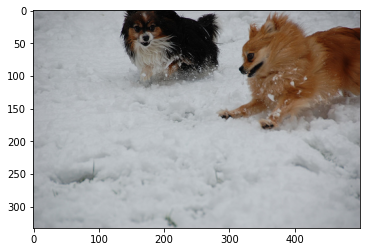

Greedy Search: a dog is running through the
Beam Search, K = 3: a brown and white dog runs through the snow 
Beam Search, K = 5: a brown and white dog runs through the snow 
Beam Search, K = 7: a brown and white dog runs through the snow 
Beam Search, K = 10: brown and white dog runs through snow 


In [125]:
#Example 1

pic = '2398605966_1d0c9e6a20.jpg'
imagex = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(imagex))
print("Beam Search, K = 3:",beam_search_predictions(imagex, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(imagex, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(imagex, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(imagex, beam_index = 10))


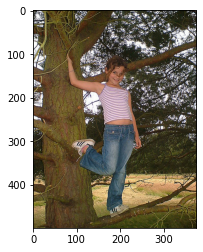

Greedy: a young girl in a ponytail is climbing a
Beam Search, K = 3: a little girl in a pink shirt is hanging upside down from a jungle gym 
Beam Search, K = 5: a little girl in a pink shirt is hanging upside down from a jungle gym 
Beam Search, K = 7: a young girl in a ponytail climbs a tree 


In [126]:
#Example 2


pic = list(encoding_test.keys())[1]
imagex = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(imagex))
print("Beam Search, K = 3:",beam_search_predictions(imagex, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(imagex, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(imagex, beam_index = 7))


In [127]:
pic

'3361990489_92244a58ef.jpg'

In [128]:
imagex.shape

(1, 2048)

### My custom **prediction**

In [135]:
mypic = './walk.jpg'

In [136]:
myimage = encode(mypic)

In [137]:
myimage.shape

(2048,)

In [138]:
myimage = myimage.reshape((1,2048))

In [139]:
myimage.shape

(1, 2048)

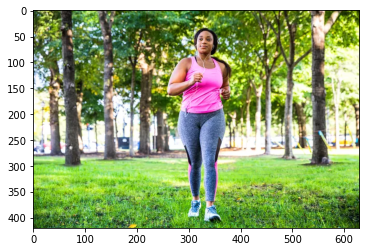

Greedy Search: a boy in a red shirt is running through a parking
Beam Search, K = 3: a young boy in a red shirt and jeans is jumping over a pile of leaves 
Beam Search, K = 5: a young boy in a red shirt and jeans stands on a cement wall 
Beam Search, K = 7: a young boy in a red shirt and jeans stands on a cement wall 


In [ ]:
x=plt.imread(mypic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(myimage))
print("Beam Search, K = 3:",beam_search_predictions(myimage, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(myimage, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(myimage, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(myimage, beam_index = 10))